In [2]:
import pandas as pd
import numpy as np
import warnings
import sys

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sktime.utils.plotting import plot_series, plot_lags, plot_correlations
#from visuals import *


#config to clean up the notebook
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')


In [3]:
#read the data and parse
df = pd.read_csv('sales_clean.csv')
df = df.set_index(['1', '2']).sort_index()
df.head()
df_sales = df[df['0'] == 'sales']
df_onpromotion = df[df['0'] == 'onpromotion']
df_sales.drop('0', axis=1, inplace=True)
df_sales.index.rename(['family', 'date'], level=[0,1], inplace=True)
df_sales = df_sales.unstack('family')
df_sales.columns = df_sales.columns.droplevel()
df_sales.head()

df_onpromotion.drop('0', axis=1, inplace=True)
df_onpromotion.index.rename(['family', 'date'], level=[0,1], inplace=True)
df_onpromotion = df_onpromotion.unstack('family')
df_onpromotion.columns = df_onpromotion.columns.droplevel()




In [4]:
#parse dates
df_sales.index = pd.to_datetime(df_sales.index)
df_onpromotion.index = pd.to_datetime(df_onpromotion.index)

In [5]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

#separate train and test
y_train = df_sales.iloc[:-15]
y_test = df_sales.iloc[-15:]





In [10]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy='last', sp=7)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)


RMSE for AUTOMOTIVE:    1.358381001891627
RMSE for BABY CARE:    0.0969352019679599
RMSE for BEAUTY:    1.6163742516734927
RMSE for BEVERAGES:    629.8133697253157
RMSE for BOOKS:    0.02191140676732531
RMSE for BREAD/BAKERY:    54.638165398252255
RMSE for CELEBRATION:    2.3688554957858448
RMSE for CLEANING:    581.5756684629596
RMSE for DAIRY:    95.19699760691029
RMSE for DELI:    41.212282499624564
RMSE for EGGS:    20.67250901534757
RMSE for FROZEN FOODS:    12.506054721096808
RMSE for GROCERY I:    791.7376935103116
RMSE for GROCERY II:    11.5325489717349
RMSE for HARDWARE:    0.19580651176327848
RMSE for HOME AND KITCHEN I:    5.854356140667163
RMSE for HOME AND KITCHEN II:    7.427266496125442
RMSE for HOME APPLIANCES:    0.15180667666099854
RMSE for HOME CARE:    78.19120871893784
RMSE for LADIESWEAR:    1.791976582463979
RMSE for LAWN AND GARDEN:    1.8161242622125413
RMSE for LINGERIE:    2.289471234711228
RMSE for LIQUOR,WINE,BEER:    22.58739890864535
RMSE for MAGAZINES: 

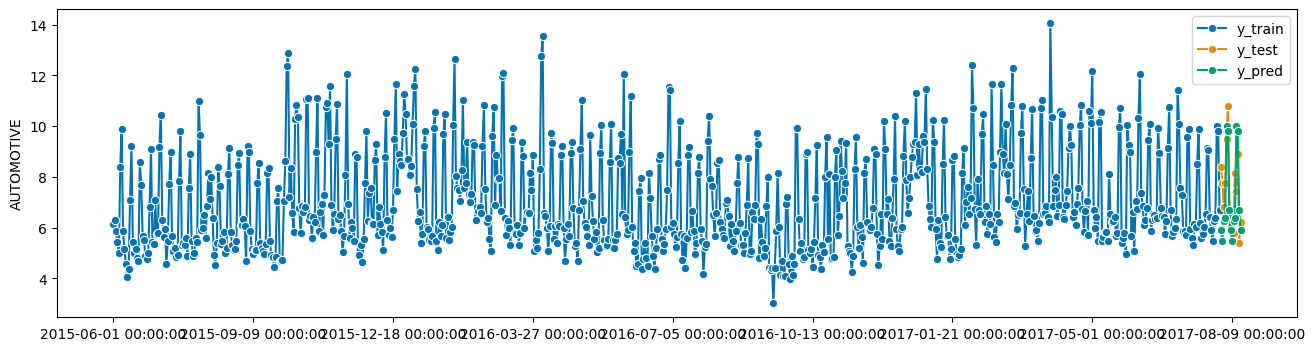

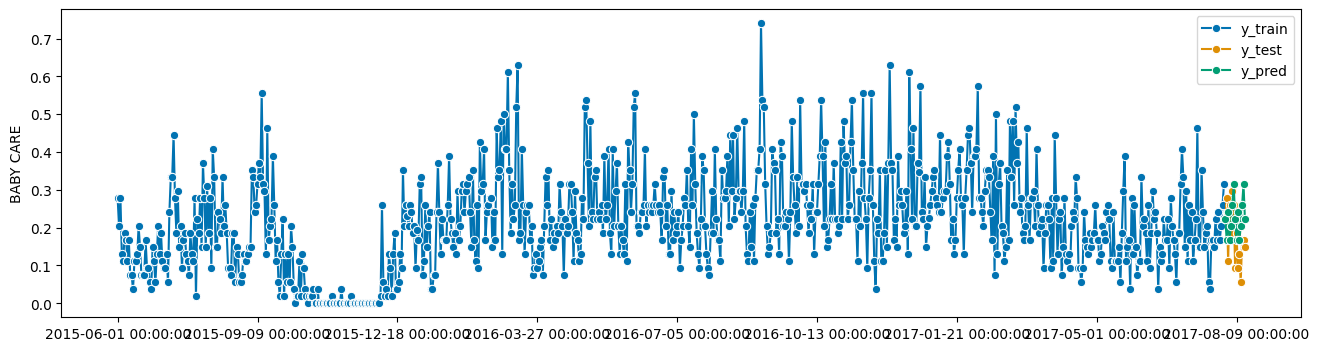

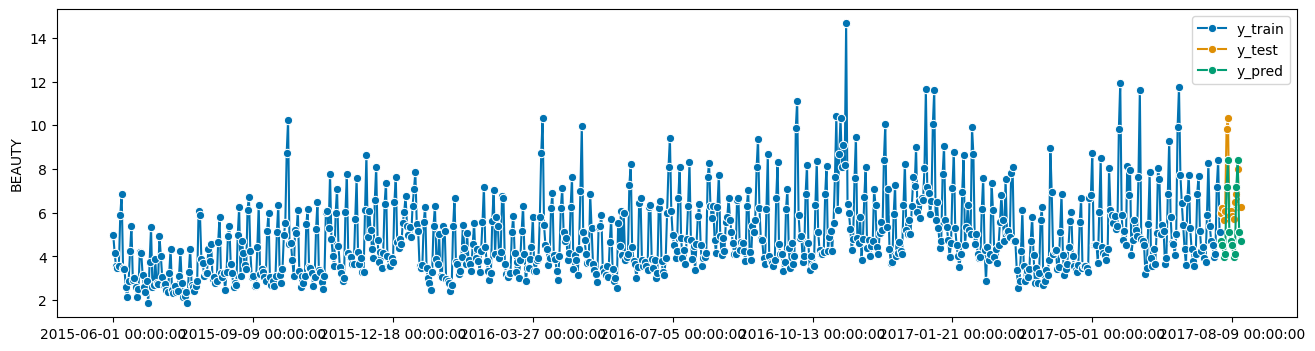

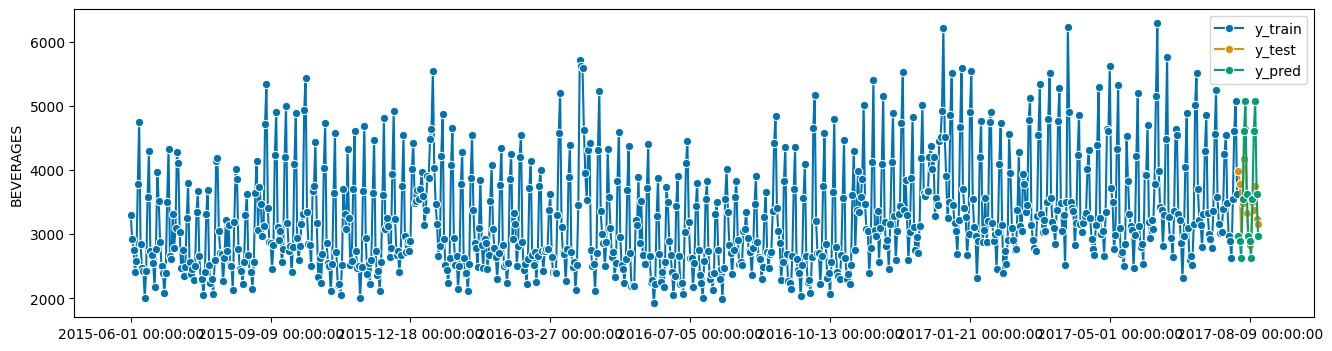

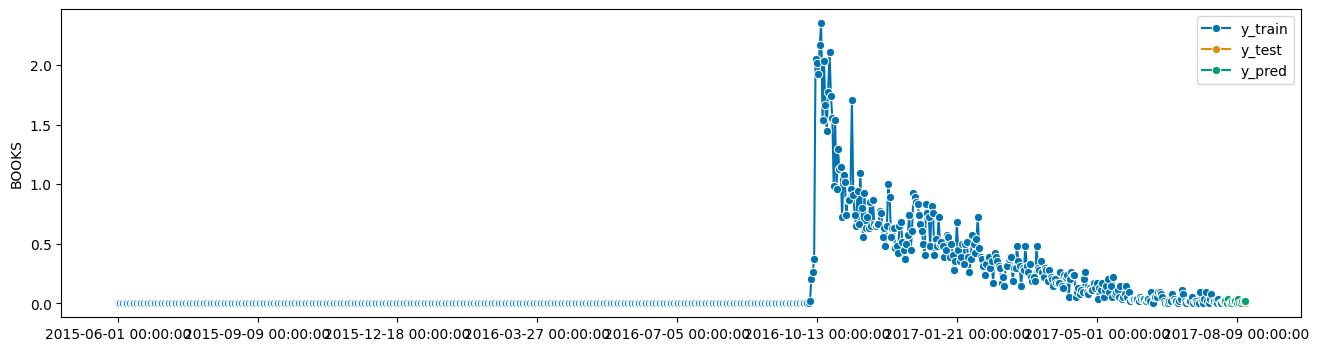

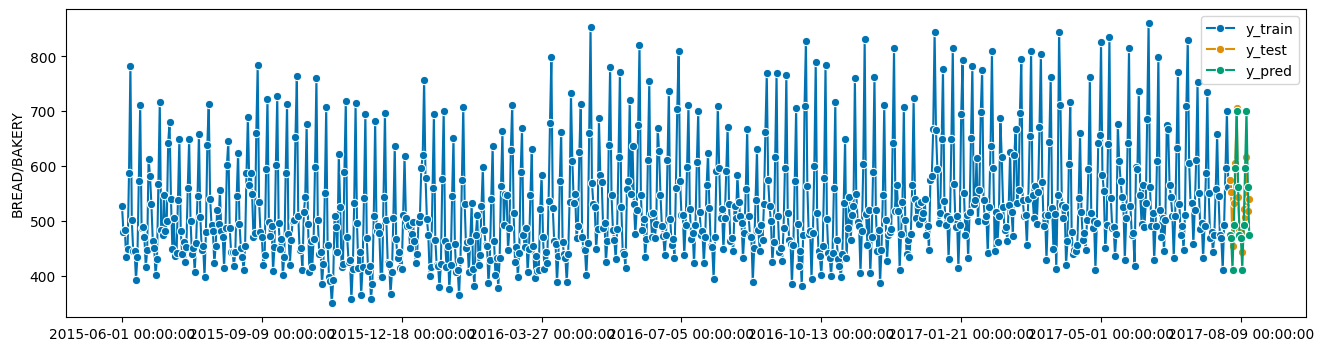

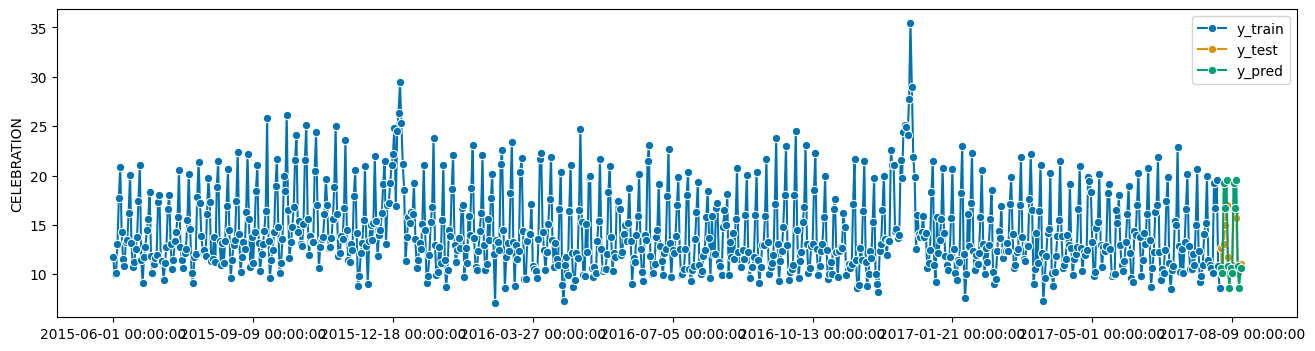

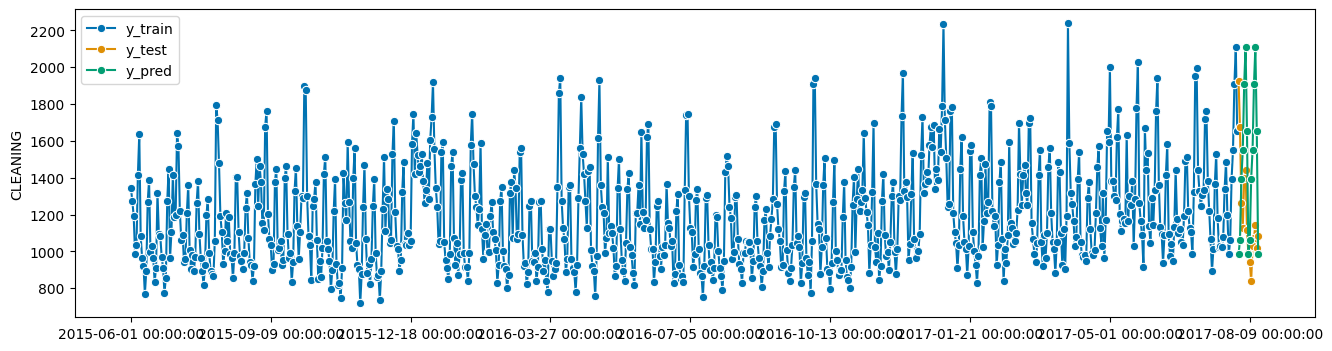

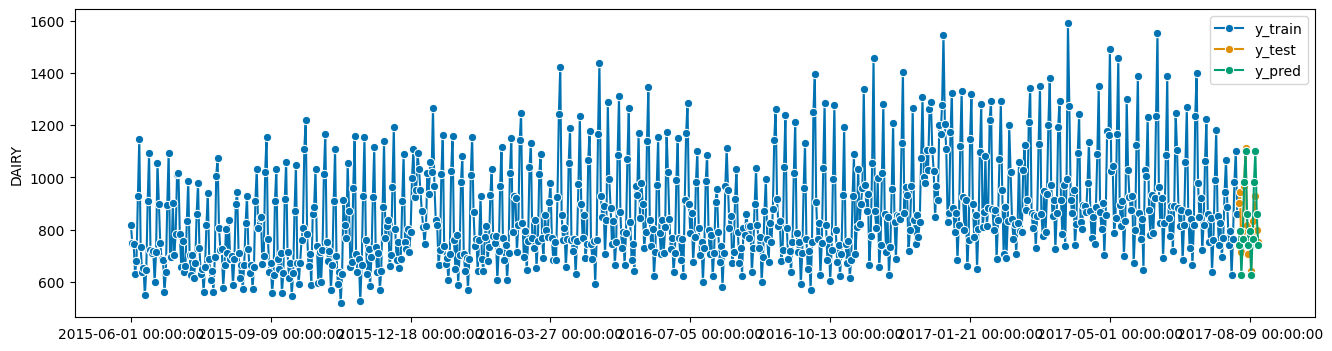

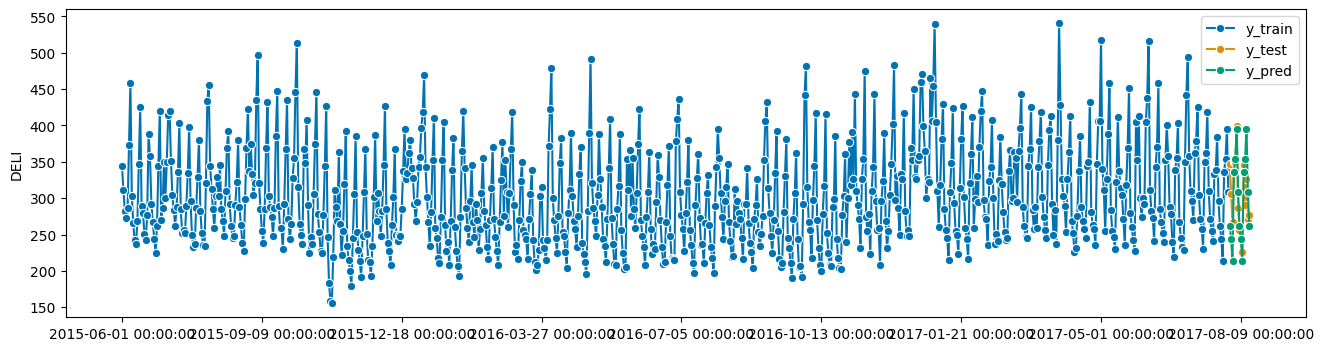

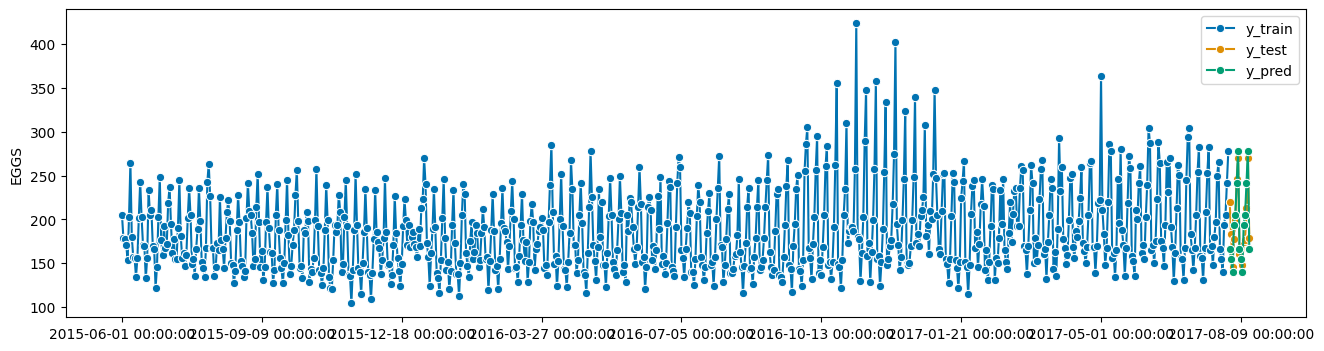

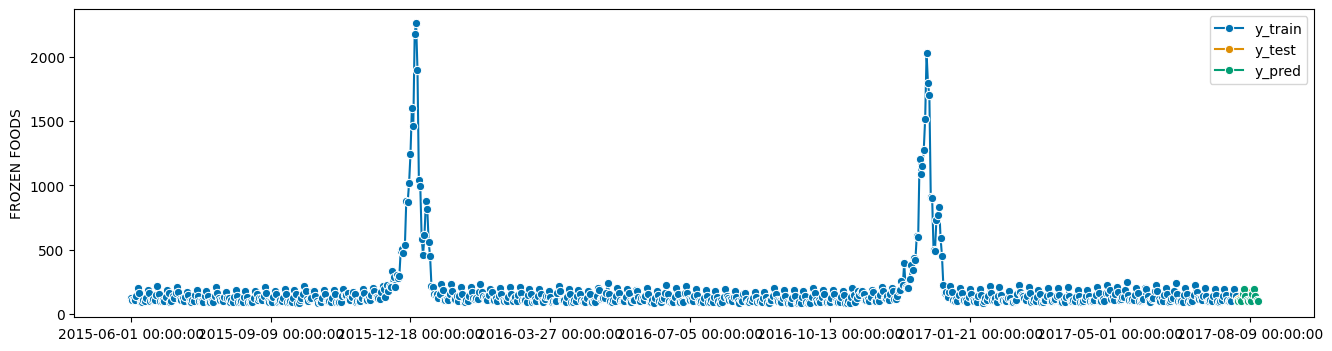

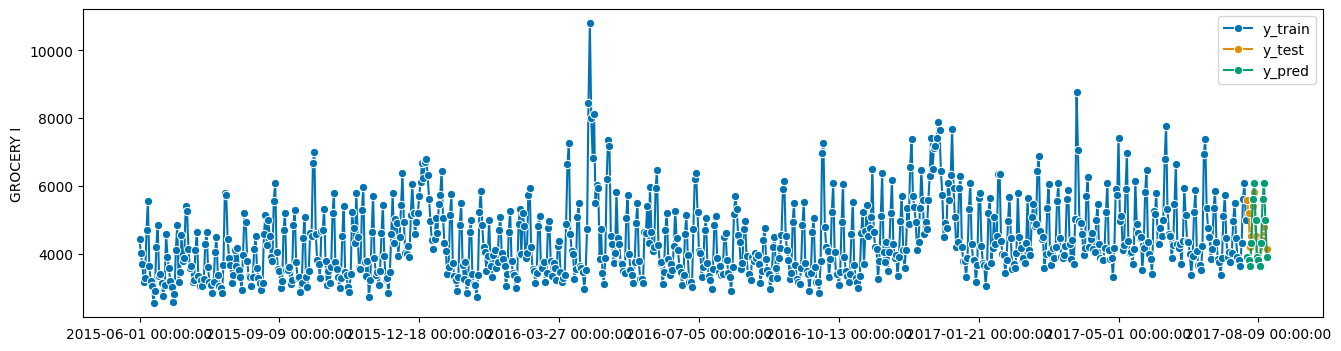

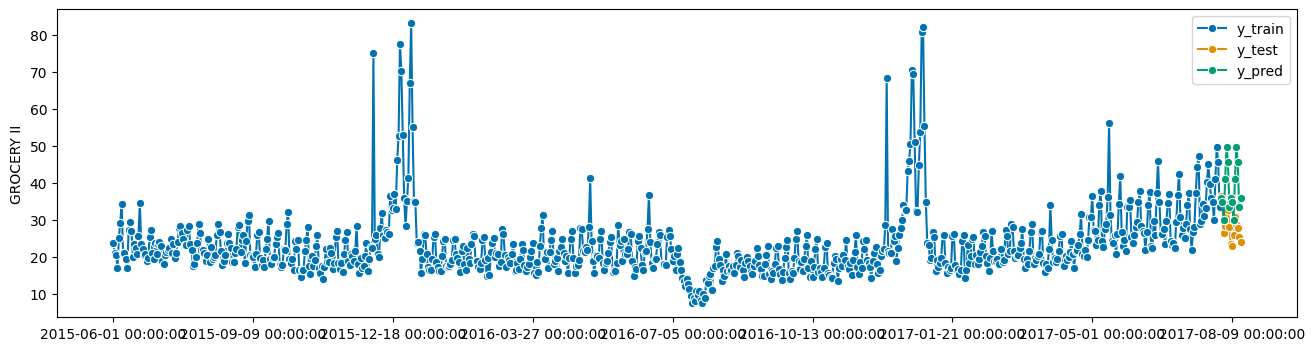

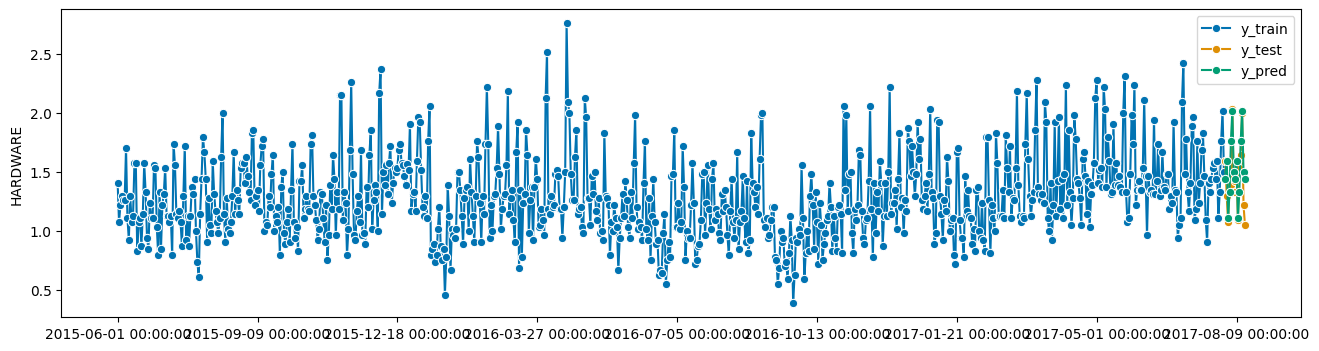

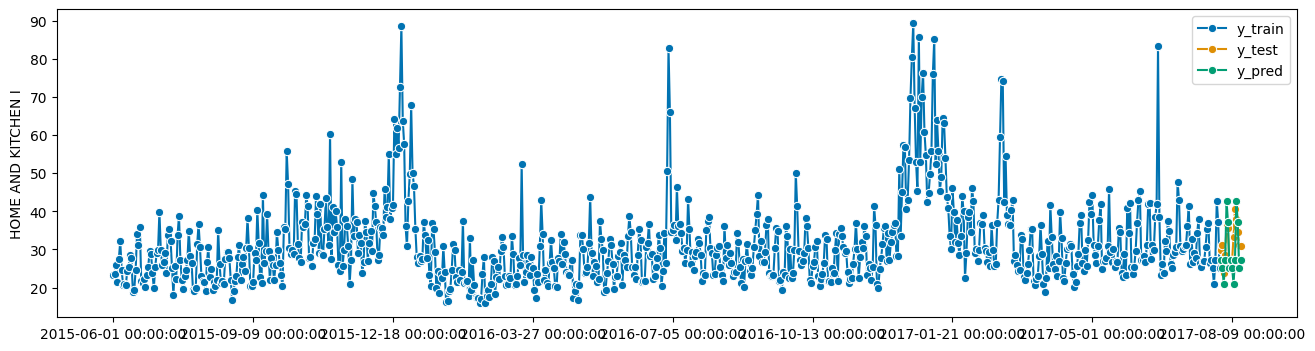

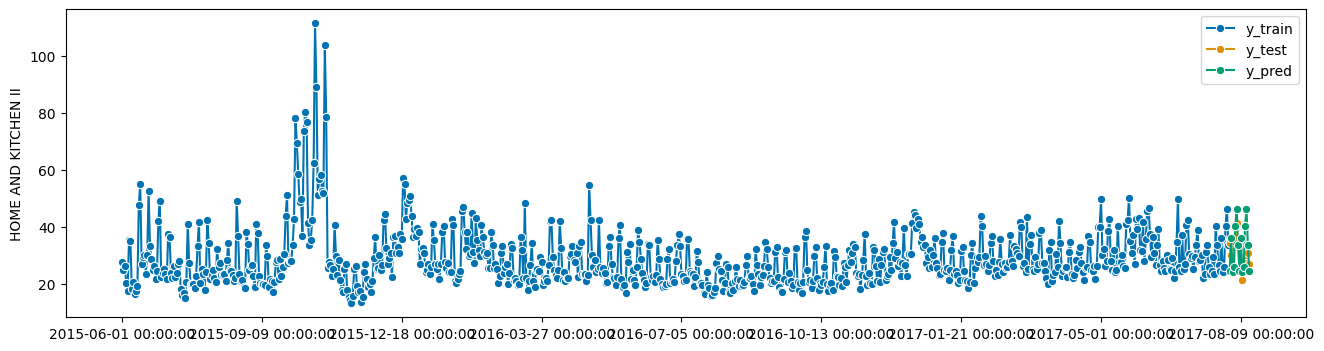

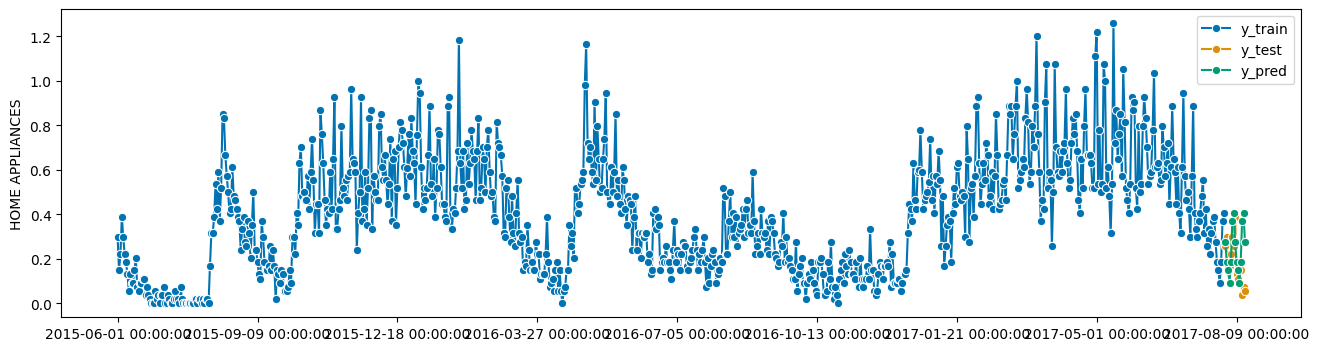

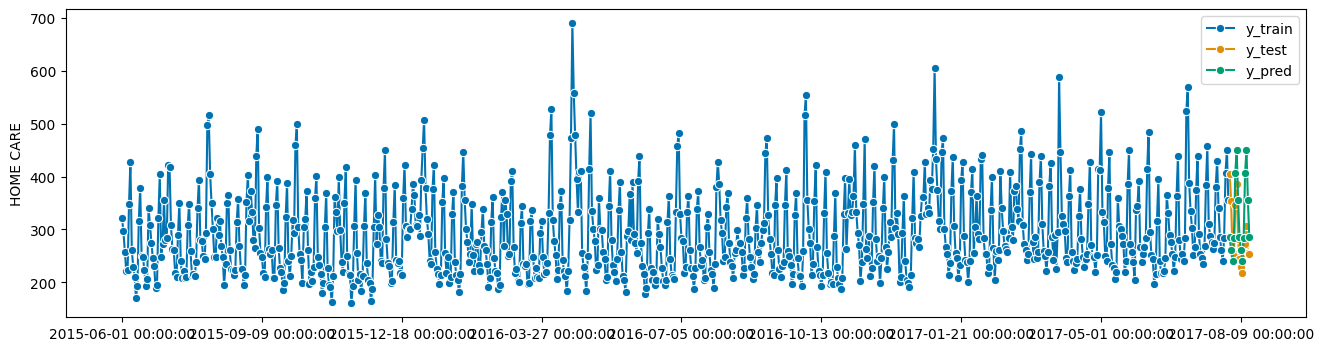

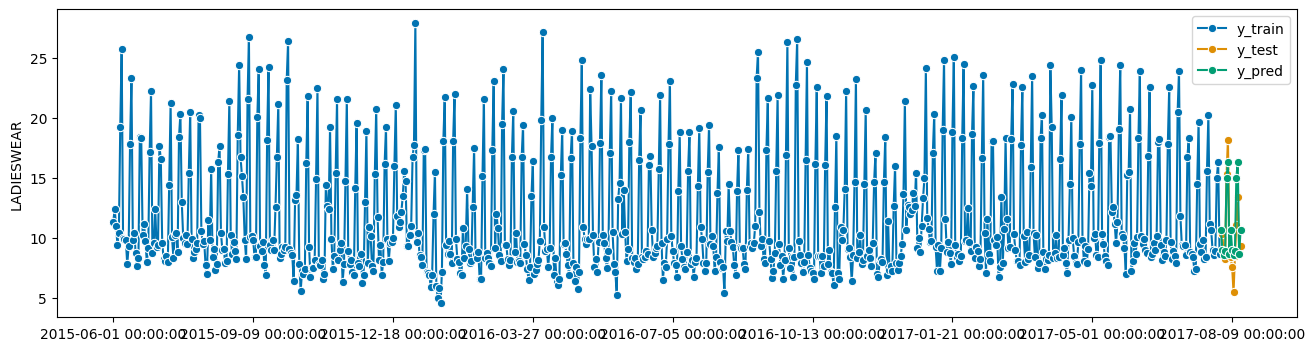

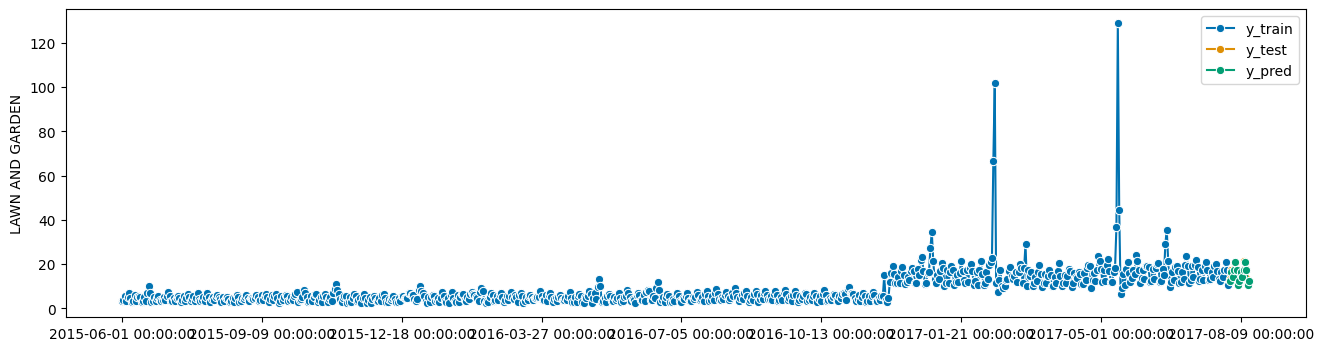

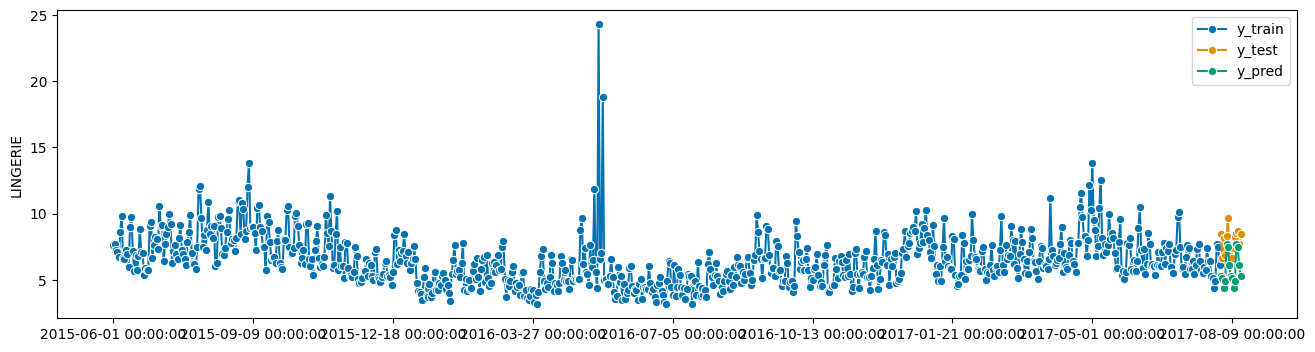

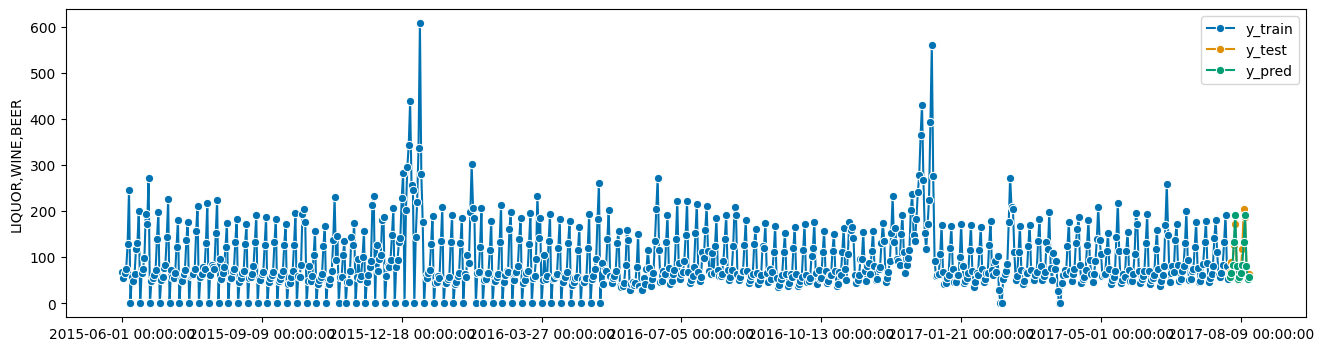

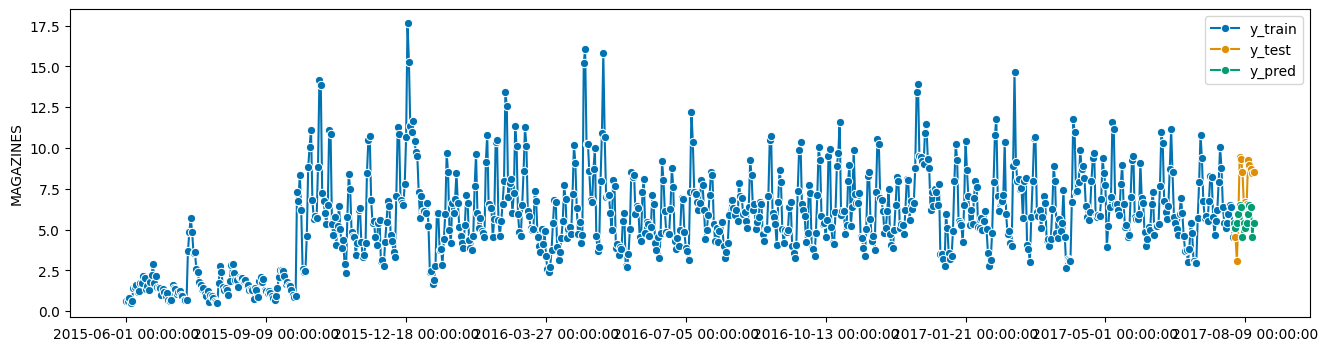

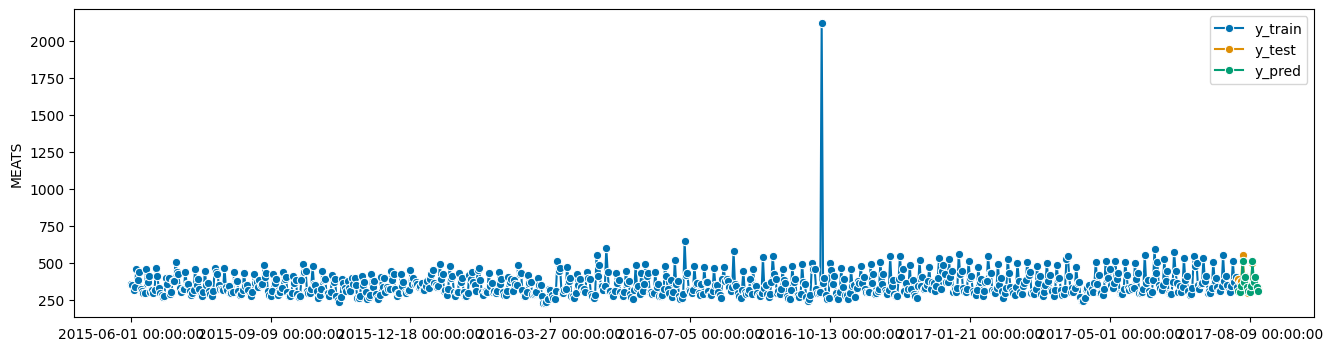

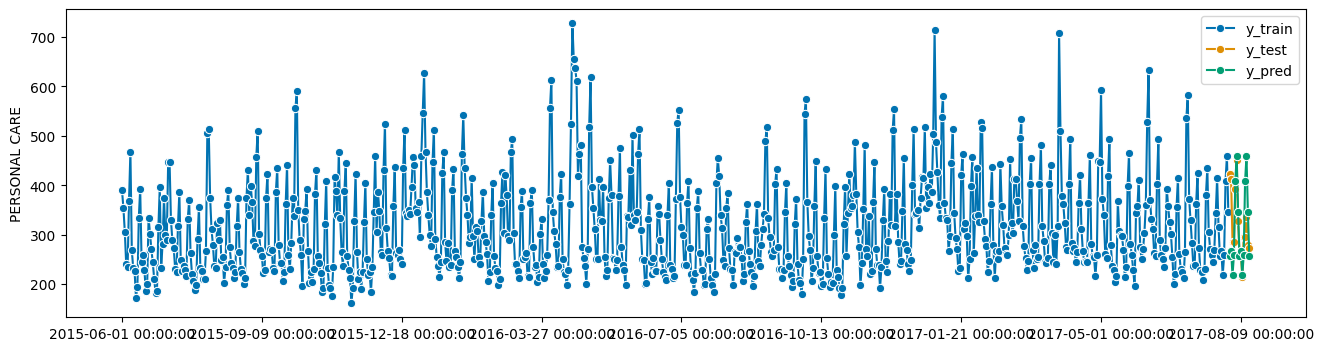

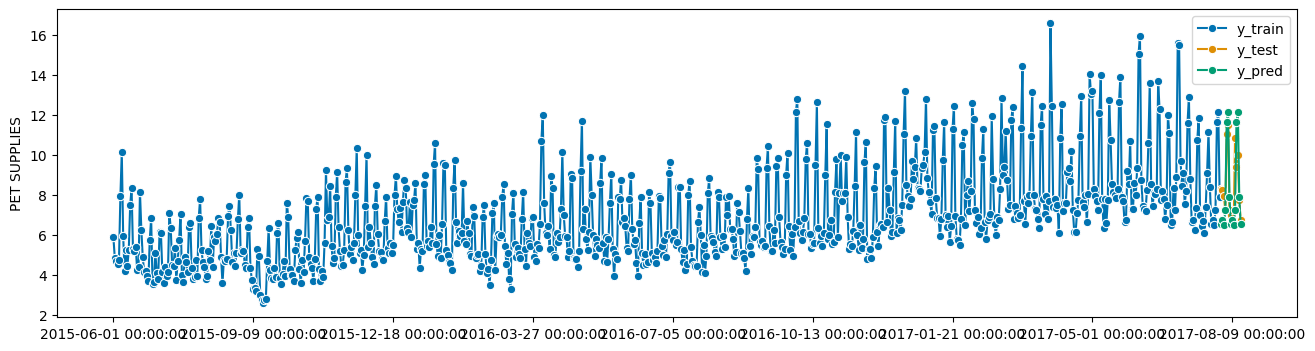

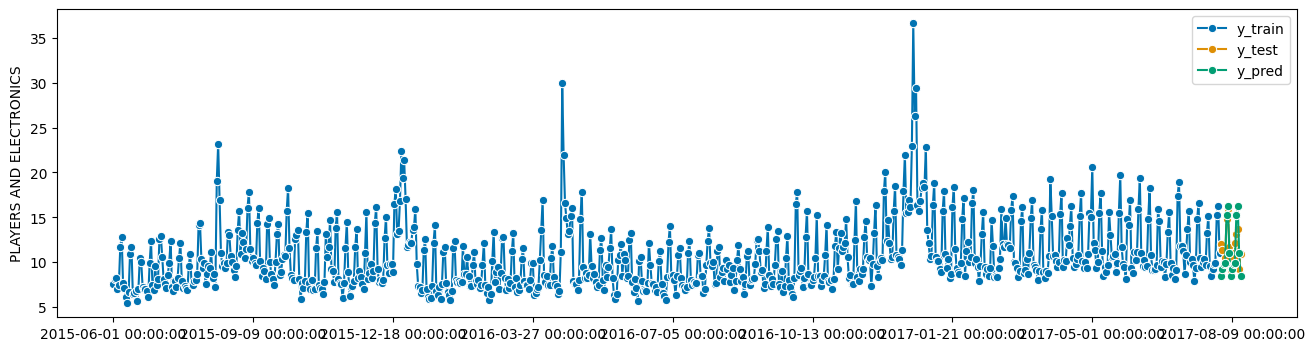

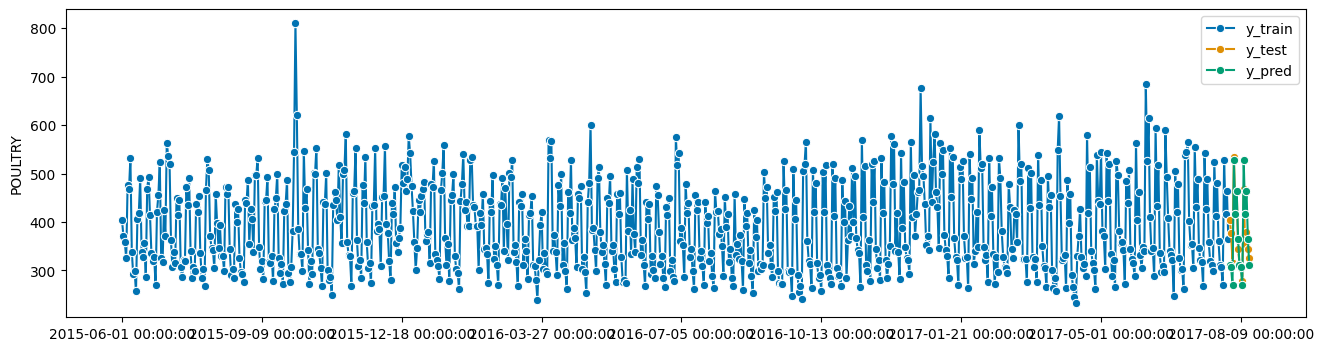

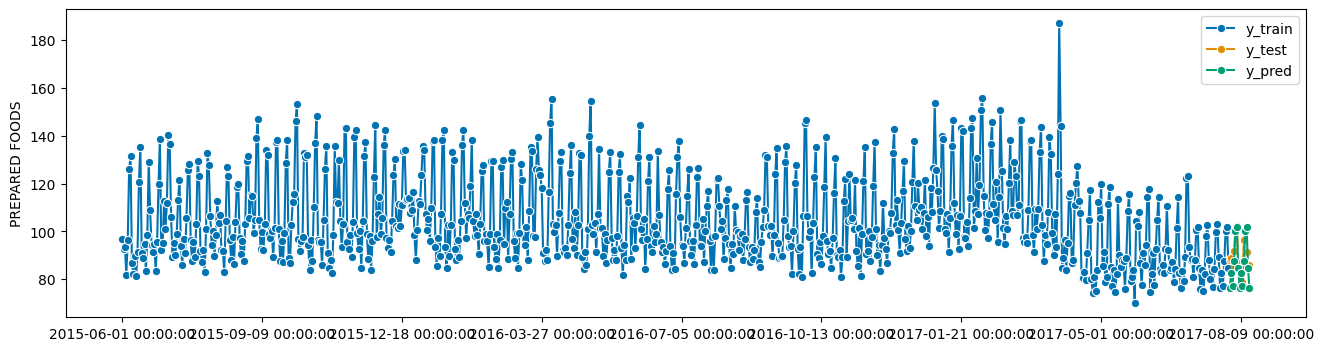

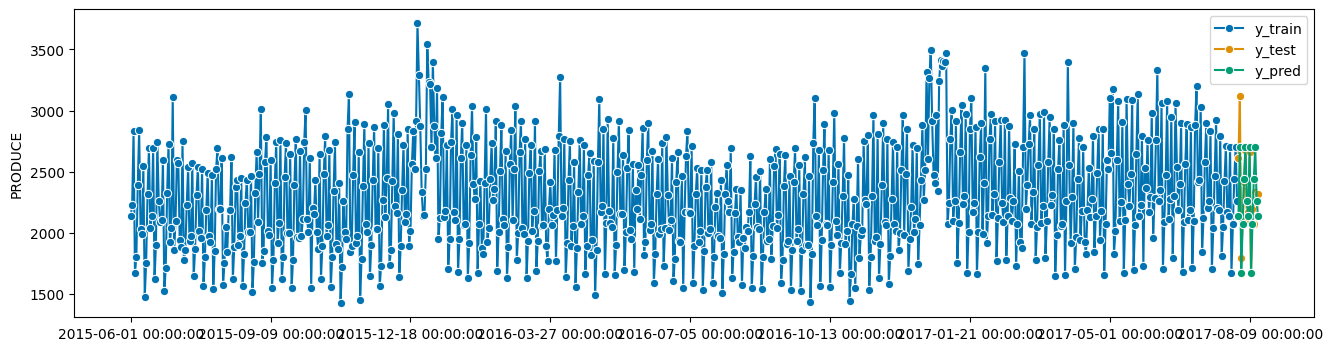

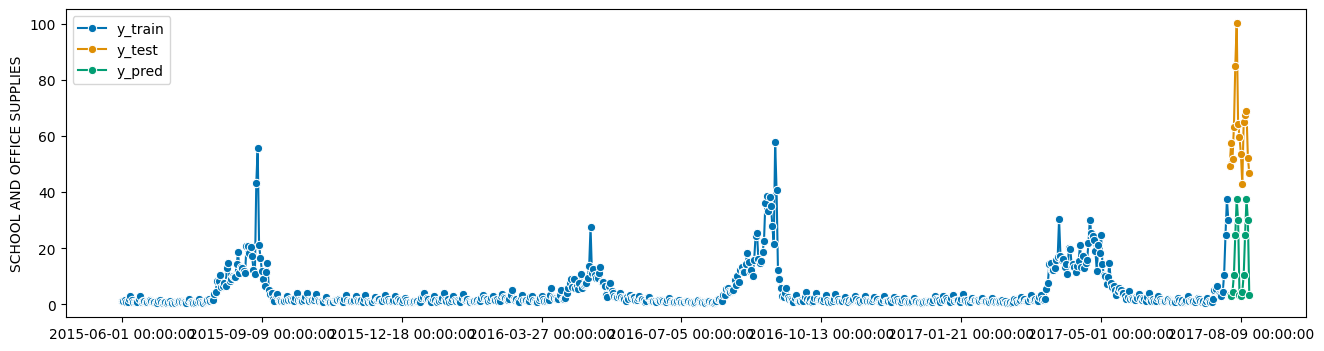

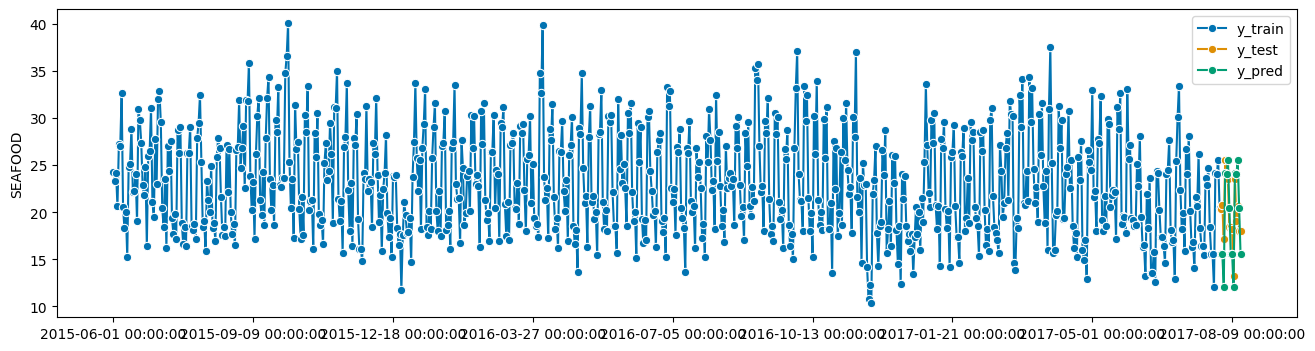

In [11]:
from sktime.performance_metrics.forecasting import MeanSquaredError

rmse = MeanSquaredError(square_root=True)

for col in y_train.columns:
    plot_series(y_train[col], y_test[col], y_pred[col], labels=['y_train', 'y_test', 'y_pred'])
    print('RMSE for {}:    {}'.format(col, rmse(y_test[col], y_pred[col])))
print('Overall RMSE {}'.format(rmse(y_test,y_pred)))

### Our first predictions
Here we have the first and simplest iteration of a predictor, using a NaiveForecaster with a seasonal period of 7 and a strategy of "last", which of means that it takes into account the previous 7 values when making its prediction. This parameter was chosen to capture some of the weekly seasonality we observed in the data.

##### Metric Selection
Here I have chosen **RMSE** or root mean squared error as the metric for evaluation. Advantages of this metric are the results are in the same unit as the target variable, which makes for good explainability downstream. It is also robust against 0 values, where something like MAPE or mean absolute percentage error is not. This could cause problems for us because some of the families like books for example, have 0 values in the ground truth for the test set.

##### Evaluating the results
We can see the results both visually and observe the RMSE. This will give us a baseline to evaluate our future iterations of modeling and prediction. **Since RMSE gives us a value in the same unit as our target variable, it represents an error in sales units, so lower will be better.**

##### Model Cross-Validation
It should be noted however, that in order to actually select the model that  generalizes the best to unseen data, we should implement a cross-validation strategy that will iteratively fit models and then test on portions of our training set. We can record the RMSE for each of these iterations and then take an average to see how well it does. While this is not a concept specific to time-series analysis, some special consideration needs to be applied to the splitting process when dealing with a time series.

The most important thing is we need to prevent data leakage, and we need to have consecutive dates in our training data.

We will be using a k-fold cv strategy that uses and expanding window strategy. This would look something like this for 5 folds (k=5)

+ signifies training data     * signifies test data  
fold 0 : ++++++++***  
fold 1 : ++++++++++++++++***  
fold 2 : ++++++++++++++++++++++++***  
fold 3 : ++++++++++++++++++++++++++++++++***  
fold 4 : ++++++++++++++++++++++++++++++++++++++++***  

In [85]:
from sklearn.model_selection import TimeSeriesSplit, KFold

#runs k fold cross validation and returns the mean of the error metric
def ts_model_cv(y_train, forecaster=None, cv=None, fh=None, metric=None):

   folds = list(cv.split_loc(y_train))
   results = []
   for n in range(cv.get_n_splits(y_train)):
      train = y_train.loc[folds[n][0]]
      test = y_train.loc[folds[n][1]]
      forecaster.fit(train)
      y_pred = forecaster.predict(fh)
      results.append(metric(test,y_pred))
      print('Fold {}: {}'.format(n, metric(test,y_pred)))
   return np.mean(results)

In [76]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
model_results = {}
fh = ForecastingHorizon(np.arange(1,16))
cv = ExpandingWindowSplitter(fh=fh, initial_window=42, step_length=15)
forecaster = NaiveForecaster(strategy='last', sp=7)
metric = MeanSquaredError(square_root=True)

results = ts_model_cv(y_train, forecaster=forecaster, cv=cv, fh=fh, metric=metric)
model_results['NaiveForecaster'] = results
print(model_results)

{'NaiveForecaster': 89.90201894253744}


##### Interpreting the Results
Here we can see that our RMSE across the 50 fold cross validation is a bit higher than the RMSE on our holdout test set. In real life we aren't going to have the ground truth values for the period we are interested in forecasting, so this cross validation performance will be a much more reliable metric to use to measure our models performance than comparing performance on the test set.

lets try a few more models

In [95]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.trend import STLForecaster

models = [
        #ExponentialSmoothing(trend='add', seasonal='add', sp=7),
        AutoARIMA(sp=7),
        #STLForecaster(seasonal=7, sp=7, trend=55, robust=True)
]

for model in models:
    model_results[str(model)] = ts_model_cv(y_train, forecaster=model, cv=cv, fh=fh, metric=metric)


Fold 0: 37.56722316734588
Fold 1: 67.28667473621381
Fold 2: 48.89007328801562
Fold 3: 80.44811088316418
Fold 4: 43.543583904051665
Fold 5: 76.40930508467474
Fold 6: 61.949251209966945
Fold 7: 80.27774328064156
Fold 8: 55.875642574761315
Fold 9: 59.55086317850294
Fold 10: 133.88787415684735
Fold 11: 125.42926609900331
Fold 12: 178.65429061321782
Fold 13: 76.27066796790204
Fold 14: 73.52108728506688
Fold 15: 56.15489153559924
Fold 16: 56.12818621406225
Fold 17: 78.79032177013453
Fold 18: 176.39439090655947
Fold 19: 87.58101808117378
Fold 20: 116.86807871845876
Fold 21: 67.18183667835213
Fold 22: 65.79165378614249
Fold 23: 68.5102177478987
Fold 24: 63.14766066366037
Fold 25: 45.58302707813617
Fold 26: 61.238648608738856
Fold 27: 69.96788855934953
Fold 28: 58.169805400545116
Fold 29: 62.08206193484601
Fold 30: 68.3185424970567
Fold 31: 76.13357758251533
Fold 32: 74.61259740503112
Fold 33: 64.55988984992439
Fold 34: 86.19734606649563
Fold 35: 171.11781752749738
Fold 36: 147.40297007475485
F

In [96]:
print(model_results)

{'NaiveForecaster': 89.90201894253744, "ExponentialSmoothing(seasonal='add', sp=7, trend='add')": 85.48038855489321, 'STLForecaster(sp=28)': 87.02852723684879, 'STLForecaster(robust=True, sp=28)': 82.25290619916618, 'STLForecaster(robust=True, sp=7)': 88.15434749345468, 'STLForecaster(robust=True, sp=7, trend=55)': 79.31962293400193}
